# Задание: 

Реализуйте нейронку для обнаружения фигур на шахматной доске:

1. Подгрузите базу, запустив ячейку ниже. База содержит папки: "Изображения", "Аннотации", а также файл obj.names с именами классов.
2. Самостоятельно сформируйте список аннотаций, приведя его в такой же вид, как в ноутбуке занятия.
3. Самостоятельно напишите все необходимые функции (можно подсматривать в ноутбук занятия), создайте и обучите модель YOLOv3. Возьмите 10% на проверочную выборку. Добейтесь минимальной ошибки на проверочной выборке. 
4. Самостоятельно напишите функцию отрисовки bboxes на картинках. Используя обученную вами модель, отрисуйте предсказанные bboxes на любых 5 картинках из тестового набора. Bboxes обязательно должны содержать название и вероятность класса объекта.


        Пожалуйста, перед выполнением ДЗ, запустите раздел "Подготовка".





## Подготовка

In [ ]:
# Импорт необходимых библиотек

# для измерения времени обучения
import time

# для создания случайных величин
import random

# Импортируем tensorflow
import tensorflow as tf 

# бэкенд Keras
import tensorflow.keras.backend as K 

# функции для детализации и управления процессом обучения
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LambdaCallback, CSVLogger

# функция для отрисовки структуры модели
from tensorflow.keras.utils import plot_model 

# Модули конвертации между RGB и HSV
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb 

# Модули работы с изображениями
from PIL import Image, ImageDraw, ImageFont 

import struct
import gdown

# библиотека numpy
import numpy as np

# Слои нейронной сети
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Lambda

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# работа со слоями
from tensorflow.keras.layers import add, concatenate

# создание моделей
from keras.models import Model

# загрузчик сохраненных моделей
from tensorflow.keras.models import load_model

# итератор, повторно возвращающий указанный объект 
from itertools import repeat

# регуляризатор, который применяет штраф за регуляризацию L2
from tensorflow.keras.regularizers import l2 

# модуль для отрисовки изображения
from tensorflow.keras.preprocessing import image 

# gрямоугольник, определяемый точкой привязки xy , а также его шириной и высотой
from matplotlib.patches import Rectangle

# возвращение списка (возможно, пустого) путей, соответствующих шаблону pathname
from glob import glob

# библиотека для работы с файлами
import os

# визуализация 
from matplotlib import pyplot as plt
%matplotlib inline  

In [ ]:
# Загрузка базы

gdown.download('https://storage.yandexcloud.net/terraai/sources/chess.zip', output=None, quiet=True)

!unzip -q chess.zip

## Решение

Извлечём нужные нам данные:

(416, 416)


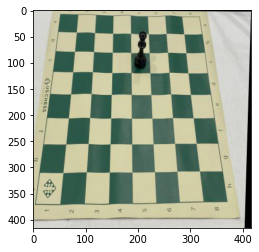

In [ ]:
# Обозначим папку с картинками 
path = '/content/Изображения/'

# извлекаем имена файлов, сортируем
img_names = sorted(os.listdir(path)) 

# отрисуем пример картинки
img = Image.open(path + img_names[0]) 
print(img.size)

plt.imshow(img)
plt.show()

Получим список названий файлов аннотаций.

In [ ]:
# Папка с файлами аннотаций
annot_path = '/content/Аннотации/' 

# Извлекаем имена файлов, сортируем
annot_names = sorted(os.listdir(annot_path)) 

print('Кол-во файлов аннотаций', len(annot_names))  
print()

# Проверяем, что названия аннотаций совпадают с названием изображений
annot_names[0], img_names[0] 

Кол-во файлов аннотаций 634



('00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.1a1407058a6170f001f2c269411d31d3.txt',
 '00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.1a1407058a6170f001f2c269411d31d3.jpg')

Получим названия классов из текстового файла.

In [ ]:
def readText(fileName):       

    ''' Функция для чтения текстовых файлов
        Args:
            fileName - путь к файлу
        Return:
            text - текст файла

        '''
    # Задаем открытие нужного файла в режиме чтения
    f = open(fileName, 'r') 

    # Читаем текст                 
    text = f.read()    

    # Переносы строки переводим в пробелы                   
    text = text.replace("\n", " ")
    
    return text 
    
classes = readText('/content/obj.names').split() # Получим названия классов
print(classes, end = '')

['black-knight', 'white-rook', 'white-pawn', 'white-king', 'white-bishop', 'black-rook', 'black-pawn', 'black-king', 'black-bishop', 'black-queen', 'white-queen', 'white-knight', 'bishop']

Приведём аннотации к такому же виду, как в занятии: `[имя файла с картинкой] [x,y,w,h,c] [x,y,w,h,c] ...`

In [ ]:
annot_list = np.array([img_names[i] + ' ' + readText(annot_path + name) for i, name in enumerate(annot_names)]) 
print(annot_list[133]  )

3730ef213ac6aad431475a9ab28f349a_jpg.rf.7529be3c45ccff8446d9464f88f8d1ae.jpg 239,2,263,50,5 351,278,385,337,5 317,111,358,196,7 242,86,273,160,9 274,37,294,81,6 281,73,301,118,6 291,147,314,191,6 297,191,319,236,6 211,104,233,148,6 211,5,231,49,6 241,26,263,81,0 179,136,207,196,0 104,286,134,345,4 58,178,89,236,4 74,1,102,47,1 60,111,96,197,3 139,89,174,161,10 145,52,169,110,11 62,224,95,285,11 179,106,199,150,2 109,1,132,46,2 113,67,136,114,2 105,236,135,285,2 185,285,214,335,2 


## Необходимые функции

Функция генерации данных. На вход приходят аннотации, на выходе получаем порцию данных для обучения.

In [ ]:
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    
    ''' Функция генерации данных
        Args: 
            annotation_lines -
            batch_size -
            anchors - 
            input_shape -
        Return:
            порция данных для обучения 

        '''

    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    
    while True:
        
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        
        for b in range(batch_size): # Пробегаем по всему batch_size
            
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            
            # Делаем аугментацию картинок и ограничивающих рамок
            image, box = augmentation(annotation_lines[i]) 
            
            # Добавляем полученную картинку в результирующий массив 
            image_data.append(image) 
            
            # Добавляем полученную ограничивающую рамку в массив bounfing_box
            box_data.append(box) 
            
            # Обновляем значение индека (не превышая общего количества элементов)
            i = (i+1) % n 
        
        # Преобразуем в numpy
        image_data = np.array(image_data)         
        box_data = np.array(box_data) 
        
        # По значению ограничивающей рамки получаем y_true 
        y_true = get_y(box_data, anchors, input_shape)        
        
        yield [image_data, *y_true], np.zeros(batch_size) 

Функция, аугментирующая изображения случайным образом.

In [ ]:
def augmentation(data):
    
    ''' Функция случайной аугментации данных
        Args: 
            annotation_lines -
            batch_size -
            anchors - 
            input_shape -
        Return:
            порция данных для обучения 

        '''

    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }
    
    # Сплитим входную строку словаря
    data = data.split() 
    
    # Открываем изображение самолета
    image = Image.open(path + data[0]) 
    
    # Получаем ширину и высоту оригинального изображения
    width_i, height_i = image.size 
    
    # Получаем ширину и высоту входного изображения для модели RetinaNet
    widht_shape, height_shape = input_shape[:2] 
    
    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])
    
    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2) 
    if new_ar < 1:        
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)
    
    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image
    
    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив
    
    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5) 
    
    if len(box)>0:                
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data
    
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box  

Функция для формирования выборки y_true - целевых значений для модели.

In [ ]:
def get_y(true_boxes, anchors, input_shape):
    
    ''' Функция подсчета y
        Args: 
            true_boxes -
            anchors -
            input_shape - 
        Return:
            ???

        '''
    # Получаем количество анкоров для каждого уровня сеток
    num_layers = len(anchors) // 3 
    
    # Задаем маску анкоров для каждого уровня
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 
    
    # Преобразуем bounding_box в numpy
    true_boxes = np.array(true_boxes, dtype='float32') 

    # Преобразуем input_shape в numpy
    input_shape = np.array(input_shape, dtype='int32') 

    # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 

    # Получаем ширину и высоту bounding_box (xRight - xLeft)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] 

    # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] 

    # Получаем высоту и ширину bounding_box В относительных значениях
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] 

    # Получаем количество элементов в batch_size
    m = true_boxes.shape[0] 

    # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] 

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2. 
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        
        if len(wh)==0: continue # Выходим если она нулевая
        
        wh = np.expand_dims(wh, -2) # Добавляем размерность
        
        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins) 
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров 

        for t, n in enumerate(best_anchor): 
            
            for l in range(num_layers):
                
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    
    return y_true

Функция-рандомайзер. Будем использовать в функции augmentation для добавления фактора случайности.

In [ ]:
def rand(a=0, b=1):
    
    return np.random.rand()*(b-a) + a

Стандартная функция ошибки yolo_loss.

In [ ]:
# Скачиваем датасет с изображениями для тестирования модели
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/yolo_chess.h5', None, quiet=True)

# Обозначим путь для весов
weights_path = '/content/yolo_chess.h5'

In [ ]:
def yolo_loss(inputs, num_anchors):

    ''' Функция рассчитывает отношение пересечение над объединениеми.
        Args:
            box1 - координаты рамки.
            box2 - координаты рамки.
        Return:
            значение ошибки IoU.
        '''
    # Порог вероятности обнаружения объекта
    ignore_thresh = .5 
    
    # Подсчитываем количество анкоров на каждом уровне сетки
    num_layers = num_anchors // 3 
    
    # Из входных данных выцепляем посчитанные моделью значения
    y_pred = inputs[:num_layers] 
    
    # Из входных данных выцепляем эталонные значения
    y_true = inputs[num_layers:] 
    
    # Задаем маску анкоров для каждого уровня сеток
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] 
   
    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0])) 
    
    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
    
    loss = 0 # Значение ошибки
    
    # Размер пакета
    m = K.shape(y_pred[0])[0] 

    # Преобразуем к типу y_pred[0]
    batch_size = K.cast(m, K.dtype(y_pred[0])) 
    
    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
       
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров). 
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])
        
        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)
        
        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])
        
        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]], 
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем 
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]
        
        # Решейпим y_pred[l]                 13                13              3              6
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5]) 
        
        # -- Считаем ошибку в определении координат центра объекта

        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats)) # три точки ... означают, что мы берем все параметры до запятой ,
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # --- Считаем ошибку в определении координат ширины и высоты

        # Получаем значения ширины и высоты изображения из спредиктенного значения   
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats)) 
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1]) 
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh)) 
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])
        
        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh]) 
        
        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh
        
        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True) 
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'
        
        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        
        def loop_body(b, ignore_mask):

            ''' 
            Функция рассчитывает отношение пересечение над объединениеми.
            Args:
                b - элемент пакета
                ignore_mask - координаты рамки.
            Return:
                b+1 - следующий элемент пакета
                ignore_mask - координаты рамки.
             '''
            
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0]) 
            
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box) 
            
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1) 
            
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box))) 
            
            return b+1, ignore_mask  
        
        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask]) 
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask
                 
        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )
        
        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)
    
        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss
                
    return loss # Возвращаем значение ошибки 

Функция подсчета коэффициента пересечения IoU.

In [ ]:
def calc_iou(input1, input2):
    
    ''' Функция подсчета коэффициента пересечения IoU
        Args: 
            input1 -
            input2 -
        Return:
            ошибка IoU 

        '''

    # Добавляем одну размерность
    input1 = K.expand_dims(input1, -2) 
    input2 = K.expand_dims(input2, 0)
    
    # Получаем координаты x,y центра 
    xy1 = input1[..., :2] 
    xy2 = input2[..., :2]

    # Получаем значения высоты и ширины
    wh1 = input1[..., 2:4] 
    wh2 = input2[..., 2:4] 
    
    # Делим значения высоты и ширины пополам
    wh_half1 = wh1 / 2. 
    wh_half2 = wh2 / 2.
    
    # Получаем значение, соответствующее верхнему левому углу
    top_left1 = xy1 - wh_half1 
    top_left2 = xy2 - wh_half2
    
    # Получаем значение, соотвествующее правому нижнему углу
    right_bottom1 = xy1 + wh_half1 
    right_bottom2 = xy2 + wh_half2

    # Берем максимальные координаты из левых верхних углов
    intersect_mins = K.maximum(top_left1, top_left2) 

    # Берем Минимальные координаты координаты из правых нижних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) 
    
    # Считаем ширину и высоту области пересечения
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) 
    
    # Считаем площадь области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] 
    
    # Считаем площадь первых элементов
    area1 = wh1[..., 0] * wh1[..., 1] 

    # Считаем площадь вторых элементов
    area2 = wh2[..., 0] * wh2[..., 1] 
    
    return intersect_area / (area1 + area2 - intersect_area) 

Определяем сверточный блок с нормализацией и активацией.

In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True, layer_idx=None): # DarknetConv2D_BN_Leaky
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        kernel - размер ядра свертки, целое число
        stride - шаг свертки, целое число
        batch_norm - включать или ветку со слоем Batchnormalization и активационной функцией LeakyReLu. 
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx+1 -номер следующего слоя

    '''
    
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm, kernel_regularizer=l2(0.0005), name='conv_' + str(layer_idx))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(layer_idx))(x)
        x = LeakyReLU(alpha=0.1,name='leake_' + str(layer_idx))(x)
    
    return x, layer_idx+1

Определяем минимальную ячейку Residual блока.

In [ ]:
def Res_unit(x, filters, layer_idx): # DarknetResidual

    '''
    Функция определяет минимальную ячейку Residual блока
    
    Args:
        x - тензор входных данных
        filter - количество фильтров на слой, целое число
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx+1 - номер следующего слоя

    '''

    skip_connection = x
    x, layer_idx = DBL(x, filters // 2, kernel=1, layer_idx=layer_idx)
    x, layer_idx = DBL(x, filters, kernel=3, layer_idx=layer_idx)
    x = add([skip_connection , x], name='Add_'+str(layer_idx))

    return x, layer_idx+1

Определяем Residual блок состоящий из входного сверточного слоя и последовательности Res_unit блоков.

In [ ]:
def ResBlock(x, filters, blocks, layer_idx): # DarknetBlock

    '''
    Функция определяет Residual блок состоящий из входного сверточного слоя 
    и последовательности Res_unit блоков
    
    Args:
        x - тензор входных данных
        filters - задает количество фильтров
        block - задает количество Residual 'ячеек', а именно, сколько раз повторить в цикле функцию Res_unit
        layer_idx - номер слоя
    
    Return:
        x - тензор выходных данных
        layer_idx -номер слоя

    '''

    x, layer_idx = DBL(x, filters, kernel=3, strides=2, layer_idx=layer_idx)
    
    for _ in repeat(None, blocks):
        x, layer_idx = Res_unit(x, filters, layer_idx=layer_idx)
    
    return x, layer_idx 

Блок для получения предсказаний конкретного уровня анкоров. В финальной модели будет 3 таких блока, по одному на каждый уровень анкоров.

In [ ]:
def Detector(x_in, filters, layer_idx=None):
   
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        x_in - тензор или список тензоров
        filters - количество фильтров
        layer_idx - номер следующего сверточного слоя
    
    Return:
        bboxes - рамки
        fork - тензор
        layer_idx -номер слоя

    '''

    if isinstance(x_in, list): # Если на вход поступает список попадаем в эту ветку (маршруты 2 и 3)
        x, x_skip = x_in[0], x_in[1]# Разбиваем список на отдельные тензоры
        x,layer_idx = DBL(x, filters, kernel=1, strides=1, layer_idx=layer_idx) # DarknetConv
        x = UpSampling2D(2, name = 'UpSampling_' + str(layer_idx))(x) # Повышаем размерность тензора
        layer_idx+=1
        x =concatenate([x, x_skip], name = 'Concatenate_' + str(layer_idx)) # Объединяем маршруты
        layer_idx+=1
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб         
    
    else: # В эту ветку попадает только маршрут 1
        x = x_in
        
        # Пять сверточных слоев DBL*5 
        for i in range(2):
          x, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 1,3
          x, layer_idx = DBL(x, filters * 2, 3, layer_idx=layer_idx)  # 2,4
        
        fork, layer_idx = DBL(x, filters, 1, layer_idx=layer_idx)      # 5 С пятого слоя каскада делаем вилку на выход и на другой масштаб 

    # Предпоследний сверточный слой (№80 13х13х1024, #92 26x26x512, #104 52x52x256)
    x,layer_idx = DBL(fork, filters=filters*2, kernel=3, strides=1, layer_idx=layer_idx)

    # Выходные слои (№81 13х13х (anchors * (4 + 1 + classes)), №93 26х26, №105 52х52 (255) 
    bboxes, layer_idx = DBL(x, filters=num_sub_anchors * (4 + 1 + num_classes), kernel=1, strides=1, batch_norm= False, layer_idx=layer_idx)       

    return bboxes, fork, layer_idx

Функция создания каркаса модели YOLOv3. Для обучения мы будем присоединять к этому каркасу необходимые входные слои, а также Lambda-слой для вычисления функции ошибки. Для получения предсказаний, мы будем использовать только этот каркас.

In [ ]:
def create_yolov3_model(inputs, num_sub_anchors, num_classes):
    
    '''
    Функция реализует блок DBL в составе моделей Darknet и YOLO
    
    Args:
        inputs - входной тензор  
        num_sub_anchors - количество анкоров 
        num_classes - количество классов
    
    Return:
        model - модель

    '''
    layer_idx = 0 # Номер первого слоя
    x, layer_idx = DBL(inputs, filters=32, kernel=3, layer_idx=layer_idx)       # DarknetConv 1 слой
    x, layer_idx = ResBlock(x, filters=64, blocks=1, layer_idx=layer_idx)            # DarknetBlock 3 слоя
    x, layer_idx = ResBlock(x, filters=128, blocks=2, layer_idx=layer_idx)           # DarknetBlock 5 слоя
    x, layer_idx = Route_1,_ = ResBlock(x, filters=256, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    x, layer_idx = Route_2,_ = ResBlock(x, filters=512, blocks=8, layer_idx=layer_idx) # DarknetBlock 9 слоев
    Route_3, layer_idx = ResBlock(x, filters=1024, blocks=4, layer_idx=layer_idx)          # последние 4 Res блока Darknet
    
    # 5 сверточных слоев DBL
    bbox_scale_1, fork_1, layer_idx = Detector(Route_3, filters=512, layer_idx=layer_idx) 

    # 82 слой на первый выход  83 пропуск
    layer_idx = 84
    bbox_scale_2, fork_2, layer_idx = Detector([fork_1, Route_2], filters=256, layer_idx=layer_idx) # 6 слоев
 
    # слои 94-95 пропущены
    layer_idx = 96
    bbox_scale_3, _, layer_idx = Detector([fork_2, Route_1], filters=128, layer_idx=layer_idx) # 6 слоев

    model = Model (inputs, [bbox_scale_1, bbox_scale_2, bbox_scale_3])

    return model

## Создание и обучение сети

Задаём необходимые параметры.

In [ ]:
size = 416 # Размер входного изображения для модели YOLO
input_shape = (size, size) # ширина, высота
channels= 3 # число цветовых каналов (RGB)
num_sub_anchors=3 # количество анкоров в каждой сетке
num_classes = len(classes) # чило классов в новом датасете

anchors = np.array([[10,13], [16,30], [33,23], [30, 61], [62,45], [59,119], [116, 90], [156, 198], [373, 326]])

num_anchors = 9 # общее количество анкоров
batch_size = 8

In [ ]:
def create_model(size, num_anchors, use_weights = False, weights_path = weights_path ):

    ''' Функция оборачивает модель YOLO для обучения

        Args:
            size - размерность входного изображения для модели YOLO
            num_anchors - общее количество анкоров (9)
            use_weights - использовать ли предобученные веса(если модель уже начали обучать)
            weights_path - путь к сохраненным весам модели
        Return:
            созданная модель  
            
            '''   
    # Создаем входной слой модели, добавляя размерность для глубины цвета
    inputs = Input(shape = (size, size, 3)) 
    
    y_true    =   [Input (shape = (size // 32, size // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (size // 16, size // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (size // 8,  size // 8,  num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)
    
    # Создаем модель YOLOv3
    model_yolo = create_yolov3_model(inputs, num_anchors // 3, num_classes) 
    
    # Выводим сообщение о создании модели
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) 
    
    # Если установлен флаг загрузки весов
    if use_weights:

        # Загружаем предобученные веса
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) 
        # Выводим сообщение о загруженных весах
        print ('Загружены веса из файла {}.'.format(weights_path)) 
        
    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])
    
    # Возвращаем модель
    return Model([inputs, *y_true], outputs) 

Создаем модель YOLOv3 для обучения.

In [ ]:
model_YOLO = create_model(size, num_anchors, use_weights=False, weights_path=weights_path)

Создана модель YOLOv3. Количество классов: 13.


Выведем структуру модели.

In [ ]:
plot_model(model_YOLO, show_shapes=True) 

Компилируем модель.

In [ ]:
optimizer = Adam(learning_rate=5e-4)

model_YOLO.compile(optimizer=optimizer, loss={'yolo_loss': lambda y_true, y_pred: y_pred})

Делим данные на обучающую и проверочную выборку.

In [ ]:
val_split = 0.1 # Коэфициент разделения на обучающую и проверочную выборку

num_val = int(len(annot_list) * val_split) # Количество элементов проверочной выборки
print (num_val)

num_train = len(annot_list) - num_val # Количество элементов обучающей выборки
print (num_train)

print (annot_list.shape)

63
571
(634,)


Задаём колбэки и запускаем обучение.

In [ ]:
# Скачиваем датасет с изображениями для тестирования модели
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l9/airplanes.zip', None, quiet=True)

# Распаковываем датасет
!unzip -q airplanes.zip -d dataset2

source_dir2 = 'dataset2/airplanes'

In [ ]:
# путь и колбэк для сохранения истории обучения

history_path = '/content/model_history_log2.csv'
csv_logger = CSVLogger(history_path, append=True) 

# уменьшение lr
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, verbose=1) 

# сохранение весов
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1) 

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit(data_generator(annot_list[:num_train], batch_size, anchors, input_shape),
                         steps_per_epoch = max (1, num_train//batch_size),
                         validation_data = data_generator(annot_list[num_train:], 
                                                          batch_size, 
                                                          anchors, 
                                                          input_shape),
                         validation_steps = max (1, num_val//batch_size), 
                         epochs = 100, 
                         verbose = 1, 
                         initial_epoch = 0, 
                         callbacks=[model_checkpoint, 
                                    reduceLROnPlateau, 
                                    csv_logger])

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1530.1100
Epoch 1: val_loss improved from inf to 736360.50000, saving model to /content/yolo_chess.h5
71/71 [==============================] - 77s 716ms/step - loss: 1530.1100 - val_loss: 736360.5000 - lr: 5.0000e-04
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 298.6007
Epoch 2: val_loss improved from 736360.50000 to 469.97476, saving model to /content/yolo_chess.h5
71/71 [==============================] - 47s 670ms/step - loss: 298.6007 - val_loss: 469.9748 - lr: 5.0000e-04
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 158.7471
Epoch 3: val_loss improved from 469.97476 to 186.58322, saving model to /content/yolo_chess.h5
71/71 [==============================] - 47s 670ms/step - loss: 158.7471 - val_loss: 186.5832 - lr: 5.0000e-04
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 113.2515
Epoch 4: val_loss improved from 186.58322 to 113.17407, saving mo

Для достижения лучшего результата, дообучим сеть с более низким LR.

In [ ]:
model_YOLO.load_weights(weights_path) # дообучим сеть, подгрузив последние веса

In [ ]:
# Уменьшаем lr
optimizer = Adam(learning_rate=1e-5)

model_YOLO.compile(optimizer=optimizer, 
                   loss={'yolo_loss': lambda y_true, y_pred: y_pred})

history_path_2 = '/content/model_history_log2_2.csv'
csv_logger = CSVLogger(history_path_2, append=True)

# уменьшение lr
reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.81, patience=3, verbose=1) 

# сохранение весов
model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=1) 

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit(data_generator(annot_list[:num_train], batch_size, anchors, input_shape),
                         steps_per_epoch = max (1, num_train//batch_size),
                         validation_data = data_generator(annot_list[num_train:], 
                                                          batch_size, 
                                                          anchors, 
                                                          input_shape),
                         validation_steps = max (1, num_val//batch_size), 
                         epochs = 50, 
                         verbose = 1, 
                         initial_epoch = 0, 
                         callbacks=[model_checkpoint, 
                                    reduceLROnPlateau, 
                                    csv_logger])

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 25.3423
Epoch 1: val_loss improved from inf to 25.42648, saving model to /content/yolo_chess.h5
71/71 [==============================] - 65s 720ms/step - loss: 25.3423 - val_loss: 25.4265 - lr: 1.0000e-05
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 24.8562
Epoch 2: val_loss improved from 25.42648 to 24.87281, saving model to /content/yolo_chess.h5
71/71 [==============================] - 46s 659ms/step - loss: 24.8562 - val_loss: 24.8728 - lr: 1.0000e-05
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 25.0252
Epoch 3: val_loss did not improve from 24.87281
71/71 [==============================] - 45s 645ms/step - loss: 25.0252 - val_loss: 25.2307 - lr: 1.0000e-05
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 24.8519
Epoch 4: val_loss improved from 24.87281 to 24.36478, saving model to /content/yolo_chess.h5
71/71 [==============================] - 47s 66

## Тестирование сети

Создадим класс для интерпретации bounding boxes. Объекты этого класса будут хранить всю необходимую информацию о bounding boxes.

In [ ]:
class BoundBox:
    
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
    
    # функция для получения значения метки
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label
   
    # получение вероятности текущей метки
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

Функция расчёта сигмоиды. Понадобится для декодирования выхода сети.

In [ ]:
def _sigmoid(x):
    
    return 1. / (1. + np.exp(-x))

Функция декодирования предсказаний сети и получения реальной информации о предсказанных bboxes.

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    
    ''' Функция декодирования выхода сети 
        Args:
            netout - 
            anchors - 
            obj_thresh - 
            net_h - 
            net_w -
        
        Return:
            boxes -
        '''
        
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 5-й элемент объектность (4-й если считать с нуля). Получаем вероятность нахождения объекта
            objectness = netout[int(row)][int(col)][b][4]
            
            if(objectness.all() <= obj_thresh): continue
            # первые 4 элемента - это x, y, w и h 
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # центральное подожение рамки относительно ширины сетки (якорного поля)
            y = (row + y) / grid_h # центральное подожение рамки относительно высоты сетки (якорного поля)
            w = anchors[2 * b + 0] * np.exp(w) / net_w # ширина рамки bbox 
            h = anchors[2 * b + 1] * np.exp(h) / net_h # высота рамки bbox
           
            # последине элементы - вероятности классов текущего объекта
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    
    return boxes

Функция, приводящая Bounding Boxes к реальным значениям.

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    
    ''' Функция, приводящая Bounding Boxes к реальным значениям 
        Args:
            boxes - 
            image_h - 
            image_w - 
            net_h - 
            net_w -
        
        Return:
            -
        '''

    new_w, new_h = net_w, net_h
    
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

Функция подсчета метрики IOU.

In [ ]:
def _interval_overlap(interval_a, interval_b):
    
    ''' Функция пересечения интервалов
        Args:
            interval_a - 
            interval_b - 
        
        Return:
            -
        '''

    x1, x2 = interval_a # Получаем нижнюю и верхнюю границу 1-го интервала
    x3, x4 = interval_b # Получаем нижнюю и верхнюю границу 2-го интервала
    
    if x3 < x1: # если начало 2-го интервала меньше начала 1-го
        
        if x4 < x1: # Если и конец 2-го интервала меньше начала 1-го
            return 0 # Интервалы не пересекаются, возвращаем 0
        else:
            return min(x2,x4) - x1 # В ином случае, возвращаем пересечение
    
    else: # Аналогичный обратный случай
        
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

In [ ]:
def intersectionOverUnion(box1, box2):
    
    ''' Функция ...
        Args:
            box1 - 
            box2 - 
        
        Return:
            -
        ''' 

    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax]) # Пересечение по ширине
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax]) # Пересечение по высоте
    intersect_area = intersect_w * intersect_h # Суммарное пересечение области

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin # Ширина и высота первого bbox
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin # Ширина и высота второго bbox

    union_area = w1*h1 + w2*h2 - intersect_area # Вычисляем объединение двух bboxes

    return float(intersect_area) / union_area # Находим IoU как соотношение пересечения и объединения

In [ ]:
def do_nms(boxes, nms_thresh): 
    
    ''' Функция подавления лишних BBox с помощью Non Maximum Suppression
        Args:
            boxes - 
            nms_thresh - 
        
        Return:
            -
        ''' 

    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if intersectionOverUnion(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
def get_boxes(boxes, labels, thresh):

    ''' Функция получения результатов, вероятность которых выше заданного порогового значения
        Args:
            boxes - 
            labels - 
            thresh -
        
        Return:
            - v_boxes, v_labels, v_scores списки, содержащие подходящие боксы
        '''     
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    #проходим в цикле по каждой рамке
    for box in boxes:
        
        # проходим в цикле по каждой вероятной метке класса
        for i in range(len(labels)):
            
            # проверяем превышает ли вероятность метки класса пороговое значение threshold
            if box.classes[i] > thresh:
                
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # для одной рамки может быть назначено несколько классов
    
    return v_boxes, v_labels, v_scores

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):

    ''' Функция отрисовки результатов
        Args:
            filename - 
            v_boxes - 
            v_labels -
            v_scores - 
        
        Return:
            -  
        '''  

    # загружаем изображение
    data = plt.imread(filename)
    plt.figure(figsize=(10,10))
    
    # строим изображение
    plt.imshow(data)
    plt.axis('off')
    
    # получаем значения осей для рисования рамок
    ax = plt.gca()
    
    # рисуем каждую рамку (bbox)
    for i in range(len(v_boxes)):
        
        box = v_boxes[i]
        
        # получаем координаты
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        
        # считаем ширину и высоту рамки
        width, height = x2 - x1, y2 - y1
        
        # создаем рамку
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        
        # накладываем рамку на изображение
        ax.add_patch(rect)
        
        # выводим текст и значения вероятностей в левом верхнем углу
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    
    # выводим все изображение
    plt.show()

In [ ]:
def load_image_pixels(filename, shape):

    ''' Функция отрисовки результатов
        Args:
            filename - 
            shape - 
        
        Return:
            - img, width, height - размер изображения 
        ''' 

    # загружаем оригинальное изображение и получаем его формат
    img = image.load_img(filename)
    width, height = img.size
    
    # загружаем изображение с заданными размерами (416х416)
    img = image.load_img(filename, target_size=shape)
    
    # преобразуем в numpy массив
    img = image.img_to_array(img)
    
    # нормируем значение пикселей в диапазоне [0, 1]
    img = img.astype('float32')
    img /= 255.0
    
    # добавляем размерность в начало 
    img = np.expand_dims(img, 0)
    
    return img, width, height

In [ ]:
def object_detection(model, file_list, labels, class_threshold=0.7, num_images=3):

    ''' Функция отрисовки результатов
        Args:
            model - модель
            file_list - списко файлов
            labels - названия классов
            class_threshold - порог вероятности
            num_images - количество изображений
        
        Return:
            - img, width, height - размер изображения 
        ''' 
        
    WIDTH, HEIGHT = 416, 416
    
    # Параметры испльзовавшиеся в наборе данных, на которых YOLOv3 был натренирован.
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    fnames = np.random.choice(np.array(file_list), num_images)
    
    for fname in fnames:
       
       # загружаем изображение
       img, image_w, image_h = load_image_pixels(path+fname, (WIDTH, HEIGHT))
    
       # анализируем фотографию
       yhat = model.predict(img)
    
       # задаем пустой лист для рамок
       boxes = list()
       for i in range(len(yhat)):
          # декодируем выход с нейросети
          boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, HEIGHT, WIDTH)

       # корректируем размеры рамкок соглсно оригинальным размера фотографий   
       correct_yolo_boxes(boxes, image_h, image_w, HEIGHT, WIDTH)

       # suppress non-maximal boxes
       do_nms(boxes, 0.5)

       # получаем рамки для обнаруженных объектов
       v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

       # Вывод информации о найденных объектах
       for i in range(len(v_boxes)):

          print(v_labels[i], v_scores[i])

       # вывод фотографий с отмеченными на них объектами
       draw_boxes(path+fname, v_boxes, v_labels, v_scores)

Формируем список названий файлов тестовых картинок.

In [ ]:
test_fnames = []

for annot in annot_list[num_train:]: # проходимся по тренировочным аннотациям
    
    fname = annot.split()[0] # извлекаем имя файла с картинкой
    test_fnames.append(f'Изобржаения/{fname}') # добавляем в общий список

Cоздаем модель YOLOv3 для предсказания.

In [ ]:
yolo3 = create_yolov3_model(Input(shape=(size, size, 3)), num_sub_anchors, num_classes)

Загружаем предобученные веса.

In [ ]:
yolo3.load_weights(weights_path)

Получаем предсказания на 10 первых картинках тестового набора.

In [ ]:
object_detection(yolo3, test_fnames[:10], classes, class_threshold=0.2, num_images=10)